c:\Users\tarun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:44:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tarun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Ensemble Model Performance:
Accuracy: 0.5183
Precision: 0.4459
Recall: 0.3666
F1 Score: 0.3673
MCC: 0.4631


c:\Users\tarun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:44:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tarun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\tarun\AppData\Local\Temp\ipykernel_11688\3397790633.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


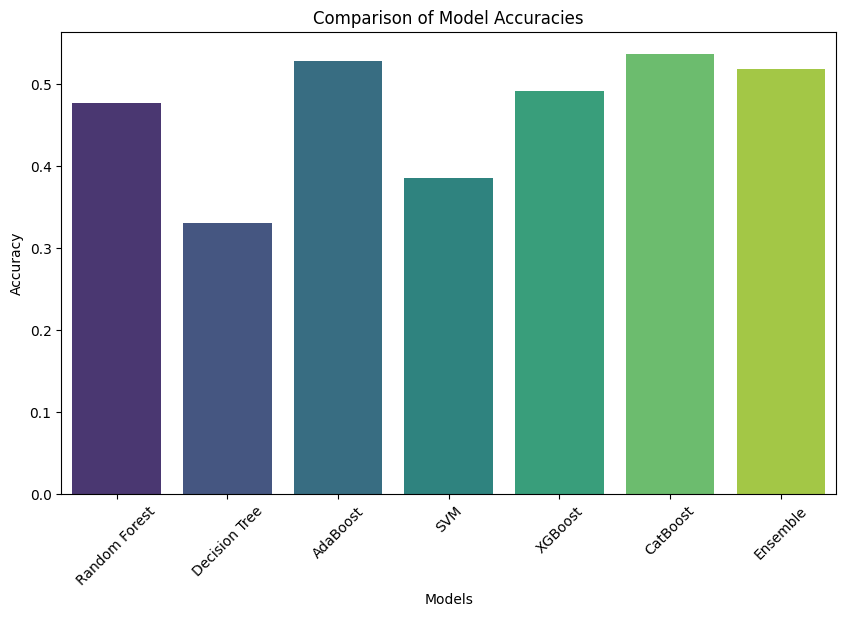

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Wrapper for CatBoost
class CatBoostClassifierWrapper(CatBoostClassifier):
    def predict(self, *args, **kwargs):
        return super().predict(*args, **kwargs).flatten()

# Load dataset
matches = pd.read_csv("d:\\IPL__DATASET\\archive\\matches.csv")
data = matches[["team1", "team2", "toss_winner", "toss_decision", "venue", "winner"]].dropna()

# Encode categorical variables
le = LabelEncoder()
for col in data.columns:
    data[col] = le.fit_transform(data[col])

# Split data
X = data.drop("winner", axis=1)
y = data["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual models
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = DecisionTreeClassifier(max_depth=5, random_state=42)
clf3 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, learning_rate=0.5, random_state=42)
clf4 = SVC(kernel='rbf', random_state=42, probability=True)
clf5 = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
clf6 = CatBoostClassifierWrapper(iterations=300, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# Create Voting Classifier
eclf1 = VotingClassifier(estimators=[('rf', clf1), ('dt', clf2), ('ada', clf3), ('svm', clf4), ('xgb', clf5), ('cat', clf6)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)

# Evaluate Ensemble Model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
mcc = matthews_corrcoef(y_test, y_pred)

print("Ensemble Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

# Compare with individual models
results = {}
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf1], ['Random Forest', 'Decision Tree', 'AdaBoost', 'SVM', 'XGBoost', 'CatBoost', 'Ensemble']):
    clf.fit(X_train, y_train)
    y_pred_individual = clf.predict(X_test)
    results[label] = accuracy_score(y_test, y_pred_individual)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.xticks(rotation=45)
plt.show()
